In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
import torch.nn as nn
from torch_geometric.loader import DataLoader  
from torch_geometric.nn import global_mean_pool, global_add_pool  
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [31]:
plt.style.use("style.mplstyle")

In [32]:
# Fix random seed
def set_seed(seed):
    import random
    random.seed(seed)  # Fix Python's random seed
    np.random.seed(seed)  # Fix NumPy's random seed
    torch.manual_seed(seed)  # Fix PyTorch's random seed
    torch.cuda.manual_seed(seed)  # Fix random seed on GPU
    torch.backends.cudnn.deterministic = True  # Ensure CuDNN determinism
    torch.backends.cudnn.benchmark = False  # Disable non-deterministic algorithm optimization

# Call at the beginning of the function
set_seed(42)  # 42 is the seed value, can be replaced with other values

In [ ]:
import torch
# Load dataset
def load_data_list(file_path):
    """
    Load a data list from a specified file path.

    Parameters:
    file_path (str): Path to the data list file.

    Returns:
    list: Loaded data list.
    """
    return torch.load(file_path)

############## Anion ##############
anion_load_file_path = 'dataset/anion_data_list.pt' # Complete dataset
anion_load_train_dataset_path = 'dataset/train_anion_data_list.pt' # Training set
anion_load_val_dataset_path = 'dataset/val_anion_data_list.pt' # Validation set
#anion_load_test_dataset_path = 'dataset/test_anion_data_list.pt' # Test set

# Load datasets
anion_loaded_data_list = load_data_list(anion_load_file_path)
anion_loaded_train_data_list = load_data_list(anion_load_train_dataset_path)
anion_loaded_val_data_list = load_data_list(anion_load_val_dataset_path)
#anion_loaded_test_data_list = load_data_list(anion_load_test_dataset_path)

# Print information about loaded datasets
print(f"Size of the loaded data list: {len(anion_loaded_data_list)}")
print(f"Size of the loaded training data list: {len(anion_loaded_train_data_list)}")
print(f"Size of the loaded validation data list: {len(anion_loaded_val_data_list)}")
#print(f"Size of the loaded test data list: {len(anion_loaded_test_data_list)}")

# Load training, validation, and test datasets
anion_train_loader = DataLoader(anion_loaded_train_data_list, batch_size=128, shuffle=True)  
anion_val_loader = DataLoader(anion_loaded_val_data_list, batch_size=128, shuffle=False)  
#anion_test_loader = DataLoader(anion_loaded_test_data_list, batch_size=128, shuffle=False)  


############## Cation ##############
cation_load_file_path = 'dataset/cation_data_list.pt' # Complete dataset
cation_load_train_dataset_path = 'dataset/train_cation_data_list.pt' # Training set
cation_load_val_dataset_path = 'dataset/val_cation_data_list.pt' # Validation set
#cation_load_test_dataset_path = 'dataset/test_cation_data_list.pt' # Test set

# Load datasets
cation_loaded_data_list = load_data_list(cation_load_file_path)
cation_loaded_train_data_list = load_data_list(cation_load_train_dataset_path)
cation_loaded_val_data_list = load_data_list(cation_load_val_dataset_path)
#cation_loaded_test_data_list = load_data_list(cation_load_test_dataset_path)

# Print information about loaded datasets
print(f"Size of the loaded data list: {len(cation_loaded_data_list)}")
print(f"Size of the loaded training data list: {len(cation_loaded_train_data_list)}")
print(f"Size of the loaded validation data list: {len(cation_loaded_val_data_list)}")
#print(f"Size of the loaded test data list: {len(cation_loaded_test_data_list)}")

# Load training, validation, and test datasets
cation_train_loader = DataLoader(cation_loaded_train_data_list, batch_size=128, shuffle=True)  
cation_val_loader = DataLoader(cation_loaded_val_data_list, batch_size=128, shuffle=False)  
#cation_test_loader = DataLoader(cation_loaded_test_data_list, batch_size=128, shuffle=False)  

In [33]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        """
        Initialization function to define the structure of the MLP.

        Parameters:
        - input_size (int): Dimension of input features, i.e., the length of each sample's feature vector.
        - hidden_sizes (list of int): List of neuron counts for the hidden layers.
        - output_size (int): Number of neurons in the output layer, typically corresponding to the number of classes for classification tasks or the target dimension for regression tasks.

        Example:
        If the input feature dimension is 20, hidden layer neuron counts are [64, 32], and output dimension is 10:
        model = MLP(input_size=20, hidden_sizes=[64, 32], output_size=10)
        """
        super(MLP, self).__init__()
        # Create a list to store layers
        layers = []
        in_dim = input_size  # Input dimension of the current layer, initially set to input_size

        # Iterate through the list of hidden layer neuron counts to construct hidden layers
        for hidden_size in hidden_sizes:
            # Add a linear layer (fully connected layer)
            layers.append(nn.Linear(in_dim, hidden_size))
            # Add ReLU activation function
            layers.append(nn.ReLU())
            in_dim = hidden_size  # Update the input dimension for the next layer

        # Add the output layer without an activation function
        layers.append(nn.Linear(in_dim, output_size))

        # Combine all layers into a sequential neural network
        self.network = nn.Sequential(*layers)

    def forward(self, data):
        """
        Forward propagation function defining how data flows through the model.

        Parameters:
        - x (Tensor): Input features, shape [batch_size, input_size]

        Returns:
        - out (Tensor): Model output, shape [batch_size, output_size]
        """
        x = data.morgan_fp  # Use molecular fingerprints as input X
        out = self.network(x)  # Pass input data through the network
        return out

In [82]:
cation_loaded_data_list[0]

Data(x=[52, 5], edge_index=[2, 102], y=[1, 17], idx=[1], name='c-c19+c-b37+c-b39+c-b81', smiles='[H]OC([H])(C([H])([H])[H])C([H])([H])C([H])([H])[P+](C([H])([H])C([H])([H])OC([H])([H])[H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H]', morgan_fp=[1, 2048], moldescriptor=[1, 183])

In [35]:
# Calculate the number of model parameters
def count_parameters(model):
    """
    Calculate the total number of parameters in the model.
    Parameters:
        model: PyTorch model
    Returns:
        total_params: Total number of parameters in the model
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

In [85]:
import torch
import torch.nn.functional as F
import numpy as np
import math

# Set device to GPU (if available), otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def training(index, loader, model, loss_fn, optimizer, input_type="fp"):
    """
    Training function to train the model for one epoch.

    Parameters:
    - loader: DataLoader object, training data loader
    - model: Model to be trained
    - loss_fn: Loss function
    - optimizer: Optimizer
    - input_type: Optional "fp" (molecular fingerprints) or "2Ddescriptors"

    Returns:
    - average_loss: Average loss for the current epoch
    """
    model.train()  # Set the model to training mode
    total_loss = 0  # Initialize total loss
    for data in loader:  # Iterate through each batch of data
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Clear gradients
        
        if input_type == "fp":
            data.morgan_fp = data.morgan_fp.float()  # Convert features to float
        elif input_type == "2Ddescriptors":
            data.moldescriptor = data.moldescriptor.float()  # Convert features to float
            
        out = model(data)  # Forward pass to compute outputs
        loss = loss_fn(out, 27.2 * data.y[:, index].view(-1, 1))  # Use only the last column of y as ground truth
        loss.backward()  # Backward pass to compute gradients
        optimizer.step()  # Update model parameters
        total_loss += loss.item()  # Accumulate loss
    average_loss = total_loss / len(loader)  # Compute average loss
    return average_loss  # Return average loss for the current epoch

def validation(index, loader, model, loss_fn, input_type="fp"):
    """
    Validation function to evaluate model performance on the validation set.

    Parameters:
    - loader: DataLoader object, validation data loader
    - model: Model to be evaluated
    - loss_fn: Loss function

    Returns:
    - average_loss: Average loss on the validation set
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0  # Initialize total loss
    with torch.no_grad():  # Disable gradient computation to save memory
        for data in loader:  # Iterate through each batch in the validation set
            data = data.to(device)  # Move data to GPU
            
            if input_type == "fp":
                data.morgan_fp = data.morgan_fp.float()  # Convert features to float
            elif input_type == "2Ddescriptors":
                data.moldescriptor = data.moldescriptor.float()  # Convert features to float

            out = model(data)  # Forward pass to compute outputs
            loss = loss_fn(out, 27.2 * data.y[:, index].view(-1, 1))  # Use only the last column of y as ground truth
            total_loss += loss.item()  # Accumulate loss
    average_loss = total_loss / len(loader)  # Compute average loss
    return average_loss  # Return average loss on the validation set

@torch.no_grad()  # Disable gradient computation to save memory
def testing(index, loader, model, input_type="fp"):
    """
    Testing function to evaluate model performance on the test set and obtain predictions.

    Parameters:
    - loader: DataLoader object, test data loader
    - model: Model to be evaluated

    Returns:
    - average_loss: Average loss on the test set
    - test_pred: Predicted values on the test set as an array
    - test_true: True target values on the test set as an array
    """
    loss_fn = torch.nn.MSELoss()  # Define mean squared error loss function
    total_loss = 0  # Initialize total loss
    test_pred = []  # List to store predicted values
    test_true = []  # List to store true values
    for data in loader:  # Iterate through each batch in the test set
        data = data.to(device)  # Move data to GPU
        
        if input_type == "fp":
            data.morgan_fp = data.morgan_fp.float()  # Convert features to float
        elif input_type == "2Ddescriptors":
            data.moldescriptor = data.moldescriptor.float()  # Convert features to float
            
        out = model(data)  # Forward pass to compute outputs
        loss = loss_fn(out, 27.2 * data.y[:, index].view(-1, 1))  # Use only the last column of y as ground truth
        total_loss += loss.item()  # Accumulate loss

        # Save predicted and true values for visualization
        test_pred.append(out.cpu().numpy())  # Move predictions to CPU and convert to numpy array
        test_true.append(data.y.cpu().numpy())  # Move true values to CPU and convert to numpy array

    test_pred = np.concatenate(test_pred, axis=0)  # Concatenate predictions from all batches
    test_true = np.concatenate(test_true, axis=0)  # Concatenate true values from all batches
    average_loss = total_loss / len(loader)  # Compute average loss
    return average_loss, test_pred, test_true  # Return test loss and predictions

def train_epochs(index, epochs, model, train_loader, val_loader, path, input_type="fp"):
    """
    Train for multiple epochs and validate after each epoch.

    Parameters:
    - epochs: Total number of training epochs
    - model: Model to be trained
    - train_loader: DataLoader object, training data loader
    - val_loader: DataLoader object, validation data loader
    - path: Path to save the best model

    Returns:
    - train_losses: Array containing training loss for each epoch
    - val_losses: Array containing validation loss for each epoch
    - train_pred: Predicted values on the training set from the last epoch
    - train_true: True target values on the training set from the last epoch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)  # Define optimizer
    loss_fn = torch.nn.MSELoss()  # Define mean squared error loss function

    train_losses = np.zeros(epochs)  # Initialize array to store training loss for each epoch
    val_losses = np.zeros(epochs)  # Initialize array to store validation loss for each epoch
    best_loss = float('inf')  # Initialize best validation loss to infinity

    for epoch in range(epochs):  # Iterate through each epoch
        # Train for one epoch and get average loss
        train_loss = training(index, train_loader, model, loss_fn, optimizer, input_type)
        # Validate the current model and get average loss
        val_loss = validation(index, val_loader, model, loss_fn, input_type)
        # Save the model if the current validation loss is less than the best loss
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), path)  # Save the current best model

        # Record losses
        train_losses[epoch] = train_loss
        val_losses[epoch] = val_loss

        # Print current training and validation loss every 2 epochs
        if epoch % 2 == 0:
            print(f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

    # Get predictions and true targets on the training set for the last epoch
    train_pred = []
    train_true = []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)  # Move data to GPU
            
            if input_type == "fp":
                data.morgan_fp = data.morgan_fp.float()  # Convert features to float
            elif input_type == "2Ddescriptors":
                data.moldescriptor = data.moldescriptor.float()  # Convert features to float
                
            out = model(data)
            train_pred.append(out.cpu().numpy())
            train_true.append(27.2 * data.y[:, index].cpu().numpy())  # Store only the last column of true values
    train_pred = np.concatenate(train_pred, axis=0)
    train_true = np.concatenate(train_true, axis=0)

    # Get predictions and true targets on the validation set for the last epoch
    val_pred = []
    val_true = []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for data in val_loader:  # Iterate through the validation set
            data = data.to(device)
            
            if input_type == "fp":
                data.morgan_fp = data.morgan_fp.float()  # Convert features to float
            elif input_type == "2Ddescriptors":
                data.moldescriptor = data.moldescriptor.float()  # Convert features to float
                
            out = model(data)  # Model predictions
            val_pred.append(out.cpu().numpy())  # Store predicted values
            val_true.append(27.2 * data.y[:, index].cpu().numpy())  # Store true values (last column)
    val_pred = np.concatenate(val_pred, axis=0)  # Concatenate predictions from all batches
    val_true = np.concatenate(val_true, axis=0)  # Concatenate true values from all batches
    
    # Compute MSE and MAE on the validation set
    mse = mean_squared_error(val_true, val_pred)
    mae = mean_absolute_error(val_true, val_pred)
    print(f"Validation MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    return train_losses, val_losses, train_pred, train_true, val_pred, val_true, mse, mae  # Return losses and predictions

In [ ]:
# Initialize the model
input_size = 2048
hidden_sizes = [512, 256, 128, 64, 32]
output_size = 1
epochs = 500
model_anion = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 
model_cation = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 

print(f"Total number of parameters in the model: {count_parameters(model_anion)}")

In [96]:

anion_mlp_train_loss, anion_mlp_val_loss, anion_mlp_train_pred, anion_mlp_train_true, anion_mlp_val_pred, anion_mlp_val_true, anion_mlp_mse, anion_mlp_mae = train_epochs(
    11, epochs, model_anion, anion_train_loader, anion_val_loader, "Anion_MLP_model_HOMO.pt"
)

Epoch: 0, Train loss: 4.8400, Val loss: 3.5456
Epoch: 2, Train loss: 0.5538, Val loss: 0.2792
Epoch: 4, Train loss: 0.1577, Val loss: 0.1484
Epoch: 6, Train loss: 0.0888, Val loss: 0.1068
Epoch: 8, Train loss: 0.0435, Val loss: 0.0760
Epoch: 10, Train loss: 0.0254, Val loss: 0.0616
Epoch: 12, Train loss: 0.0178, Val loss: 0.0536
Epoch: 14, Train loss: 0.0129, Val loss: 0.0499
Epoch: 16, Train loss: 0.0102, Val loss: 0.0486
Epoch: 18, Train loss: 0.0080, Val loss: 0.0453
Epoch: 20, Train loss: 0.0063, Val loss: 0.0431
Epoch: 22, Train loss: 0.0055, Val loss: 0.0430
Epoch: 24, Train loss: 0.0040, Val loss: 0.0416
Epoch: 26, Train loss: 0.0048, Val loss: 0.0441
Epoch: 28, Train loss: 0.0033, Val loss: 0.0428
Epoch: 30, Train loss: 0.0033, Val loss: 0.0414
Epoch: 32, Train loss: 0.0029, Val loss: 0.0422
Epoch: 34, Train loss: 0.0040, Val loss: 0.0424
Epoch: 36, Train loss: 0.0035, Val loss: 0.0420
Epoch: 38, Train loss: 0.0036, Val loss: 0.0421
Epoch: 40, Train loss: 0.0031, Val loss: 0.04

In [97]:
cation_mlp_train_loss, cation_mlp_val_loss, cation_mlp_train_pred, cation_mlp_train_true, cation_mlp_val_pred, cation_mlp_val_true, cation_mlp_mse, cation_mlp_mae = train_epochs(
    12, epochs, model_cation, cation_train_loader, cation_val_loader, "Cation_MLP_model_LUMO.pt"
)


Epoch: 0, Train loss: 17.6921, Val loss: 2.2216
Epoch: 2, Train loss: 0.4038, Val loss: 0.3137
Epoch: 4, Train loss: 0.1358, Val loss: 0.1583
Epoch: 6, Train loss: 0.0777, Val loss: 0.1222
Epoch: 8, Train loss: 0.0550, Val loss: 0.1074
Epoch: 10, Train loss: 0.0429, Val loss: 0.0999
Epoch: 12, Train loss: 0.0346, Val loss: 0.0941
Epoch: 14, Train loss: 0.0294, Val loss: 0.0937
Epoch: 16, Train loss: 0.0272, Val loss: 0.0895
Epoch: 18, Train loss: 0.0246, Val loss: 0.0893
Epoch: 20, Train loss: 0.0224, Val loss: 0.0894
Epoch: 22, Train loss: 0.0216, Val loss: 0.0881
Epoch: 24, Train loss: 0.0206, Val loss: 0.0863
Epoch: 26, Train loss: 0.0207, Val loss: 0.0871
Epoch: 28, Train loss: 0.0197, Val loss: 0.0880
Epoch: 30, Train loss: 0.0181, Val loss: 0.0850
Epoch: 32, Train loss: 0.0178, Val loss: 0.0902
Epoch: 34, Train loss: 0.0168, Val loss: 0.0893
Epoch: 36, Train loss: 0.0159, Val loss: 0.0863
Epoch: 38, Train loss: 0.0158, Val loss: 0.0862
Epoch: 40, Train loss: 0.0159, Val loss: 0.0

In [98]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_loss(gcn_train_loss, gcn_val_loss):
    # Plot loss curves
    plt.plot(gcn_train_loss, label="Train loss")
    plt.plot(gcn_val_loss, label="Val loss")
    plt.legend()  # Add legend
    
    plt.ylabel("Loss")  # Set Y-axis label
    plt.xlabel("Epoch")  # Set X-axis label
    plt.title("Model Loss")  # Set title
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Set X-axis ticks as integers
    plt.show()  # Display the plot

def plot_targets(pred, ground_truth, mse, mae, save_path="MLP_val.png"):
    from sklearn.metrics import r2_score
    
    # Calculate R² (coefficient of determination)
    r2 = r2_score(ground_truth, pred)    

    # Plot scatter plot comparing predicted values and ground truth
    f, ax = plt.subplots(figsize=(1.75, 1.75))  # Create figure and axis objects
    ax.scatter(pred, ground_truth, s=0.5)  # Plot scatter points
    ax.axline((1, 1), slope=1, color="red", linestyle="--")  # Add reference line
    plt.xlabel("Predicted Value")  # Set X-axis label
    plt.ylabel("Ground Truth")  # Set Y-axis label
    # plt.title("Ground Truth vs Prediction")  # Set title

    # Display MAE and MSE in the top left corner
    text_str = f"MAE = {mae:.2f}\nMSE = {mse:.2f}\nR² = {r2:.2f}\nParameters = {count_parameters(model)}"
    plt.text(
        0.05, 0.95, text_str,
        transform=ax.transAxes,  # Use axis coordinates for positioning
        fontsize=7, color="black",
        verticalalignment="top", horizontalalignment="left"
    )
    # Save the image
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # Save the image with 300 DPI resolution
    plt.show()  # Display the plot

In [114]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_cation_anion_targets(cation_pred, cation_ground_truth, anion_pred, anion_ground_truth, title="GAT", save_path="GAT_cation_anion_val.png"):
    # Calculate the number of model parameters
    parameters = count_parameters(model)
    
    # Create figure and axis objects
    fig, ax = plt.subplots(figsize=(1.75, 1.75))
    
    # Plot scatter points for cations (red)
    ax.scatter(cation_pred, cation_ground_truth, s=0.5, color='#f7c0c5', label='Cation')
    
    # Plot scatter points for anions (blue)
    ax.scatter(anion_pred, anion_ground_truth, s=0.5, color='#bfcfe4', label='Anion')
    
    # Add reference line y = x
    ax.axline((0, 0), slope=1, color="gray", linestyle="--")
    
    # Set axis labels
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground Truth")
    
    # Display labels in the legend
    ax.legend(loc='lower right')
    plt.title(title)
    # Display the number of model parameters in the top left corner
    text_str = f"Parameters = {parameters}"
    plt.text(
        0.05, 0.95, text_str,
        transform=ax.transAxes,
        fontsize=7, color="black",
        verticalalignment="top", horizontalalignment="left"
    )
    
    # Save the image
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

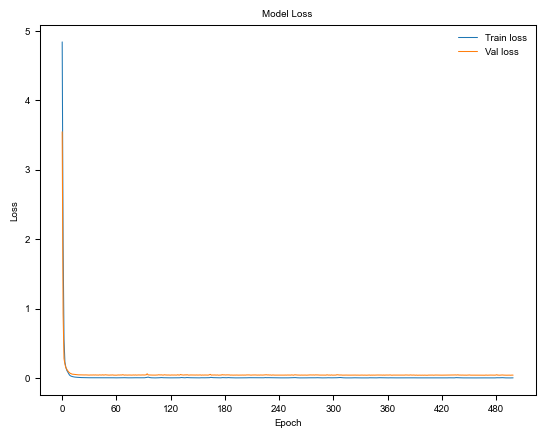

In [100]:
plot_loss(anion_mlp_train_loss, anion_mlp_val_loss)

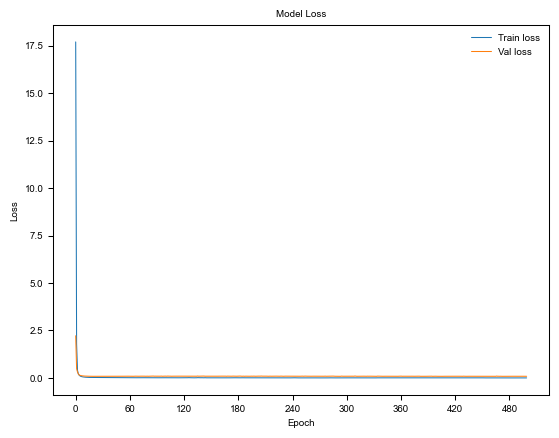

In [101]:
plot_loss(cation_mlp_train_loss, cation_mlp_val_loss)

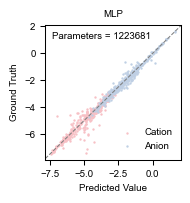

In [115]:
plot_cation_anion_targets(cation_mlp_val_pred_2Ddescriptors, cation_mlp_val_true_2Ddescriptors, anion_mlp_val_pred_2Ddescriptors,
                          anion_mlp_val_true_2Ddescriptors, title="MLP", save_path="MLP_cation_anion_val_2Ddescriptors.png")

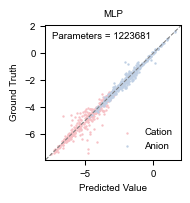

In [116]:
plot_cation_anion_targets(cation_mlp_val_pred, cation_mlp_val_true, anion_mlp_val_pred,
                          anion_mlp_val_true, title="MLP", save_path="MLP_cation_anion_val.png")

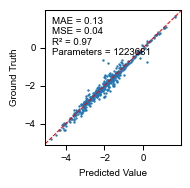

In [104]:
plot_targets(anion_mlp_val_pred, anion_mlp_val_true, anion_mlp_mse, anion_mlp_mae, save_path="anion_MLP_val_HOMO.png")

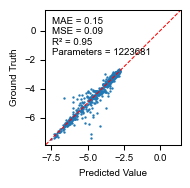

In [105]:
plot_targets(cation_mlp_val_pred, cation_mlp_val_true, cation_mlp_mse, cation_mlp_mae, save_path="cation_MLP_val_LUMO.png")

# 25% train dataset

In [106]:
anion_25_load_train_dataset_path = 'dataset/train_anion_data_list_25.pt'
anion_25_loaded_train_data_list = load_data_list(anion_25_load_train_dataset_path)
anion_25_train_loader = DataLoader(anion_25_loaded_train_data_list, batch_size=128, shuffle=True)  

cation_25_load_train_dataset_path = 'dataset/train_cation_data_list_25.pt'
cation_25_loaded_train_data_list = load_data_list(cation_25_load_train_dataset_path)
cation_25_train_loader = DataLoader(cation_25_loaded_train_data_list, batch_size=128, shuffle=True)  

In [107]:
# Train the GCN model with the number of epochs set to 100
epochs = 500

input_size = 2048
hidden_sizes = [512, 256, 128, 64, 32]
output_size = 1

# Initialize the GCN model with a hidden layer dimension of 256
model_anion_25 = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device)
model_cation_25 = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device)

In [108]:
anion_mlp_train_loss_25, anion_mlp_val_loss_25, anion_mlp_train_pred_25, anion_mlp_train_true_25, anion_mlp_val_pred_25, anion_mlp_val_true_25, anion_mlp_mse_25, anion_mlp_mae_25 = train_epochs(
    11, epochs,model_anion_25, anion_25_train_loader, anion_val_loader, "Anion_MLP_model_HOMO_25.pt"
)

Epoch: 0, Train loss: 4.8301, Val loss: 4.4680
Epoch: 2, Train loss: 3.8575, Val loss: 3.1899
Epoch: 4, Train loss: 1.2641, Val loss: 0.9638
Epoch: 6, Train loss: 0.7419, Val loss: 0.5456
Epoch: 8, Train loss: 0.4501, Val loss: 0.4266
Epoch: 10, Train loss: 0.2257, Val loss: 0.2460
Epoch: 12, Train loss: 0.1469, Val loss: 0.2645
Epoch: 14, Train loss: 0.1163, Val loss: 0.1934
Epoch: 16, Train loss: 0.0967, Val loss: 0.1993
Epoch: 18, Train loss: 0.0839, Val loss: 0.1828
Epoch: 20, Train loss: 0.0729, Val loss: 0.1819
Epoch: 22, Train loss: 0.0781, Val loss: 0.1677
Epoch: 24, Train loss: 0.0674, Val loss: 0.1675
Epoch: 26, Train loss: 0.0521, Val loss: 0.1558
Epoch: 28, Train loss: 0.0383, Val loss: 0.1472
Epoch: 30, Train loss: 0.0229, Val loss: 0.1430
Epoch: 32, Train loss: 0.0186, Val loss: 0.1421
Epoch: 34, Train loss: 0.0150, Val loss: 0.1360
Epoch: 36, Train loss: 0.0099, Val loss: 0.1336
Epoch: 38, Train loss: 0.0080, Val loss: 0.1322
Epoch: 40, Train loss: 0.0053, Val loss: 0.12

In [109]:
cation_mlp_train_loss_25, cation_mlp_val_loss_25, cation_mlp_train_pred_25, cation_mlp_train_true_25, cation_mlp_val_pred_25, cation_mlp_val_true_25, cation_mlp_mse_25, cation_mlp_mae_25 = train_epochs(
    12, epochs,model_cation_25, cation_25_train_loader, cation_val_loader, "Cation_MLP_model_LUMO_25.pt"
)

Epoch: 0, Train loss: 22.0495, Val loss: 21.2311
Epoch: 2, Train loss: 17.8081, Val loss: 13.6203
Epoch: 4, Train loss: 3.0928, Val loss: 4.2205
Epoch: 6, Train loss: 1.1067, Val loss: 1.2710
Epoch: 8, Train loss: 0.4767, Val loss: 0.5716
Epoch: 10, Train loss: 0.2981, Val loss: 0.3851
Epoch: 12, Train loss: 0.1814, Val loss: 0.3005
Epoch: 14, Train loss: 0.1304, Val loss: 0.2655
Epoch: 16, Train loss: 0.0996, Val loss: 0.2422
Epoch: 18, Train loss: 0.0791, Val loss: 0.2208
Epoch: 20, Train loss: 0.0632, Val loss: 0.2063
Epoch: 22, Train loss: 0.0513, Val loss: 0.1969
Epoch: 24, Train loss: 0.0423, Val loss: 0.1885
Epoch: 26, Train loss: 0.0352, Val loss: 0.1817
Epoch: 28, Train loss: 0.0298, Val loss: 0.1762
Epoch: 30, Train loss: 0.0258, Val loss: 0.1703
Epoch: 32, Train loss: 0.0218, Val loss: 0.1665
Epoch: 34, Train loss: 0.0190, Val loss: 0.1642
Epoch: 36, Train loss: 0.0167, Val loss: 0.1604
Epoch: 38, Train loss: 0.0153, Val loss: 0.1571
Epoch: 40, Train loss: 0.0131, Val loss: 

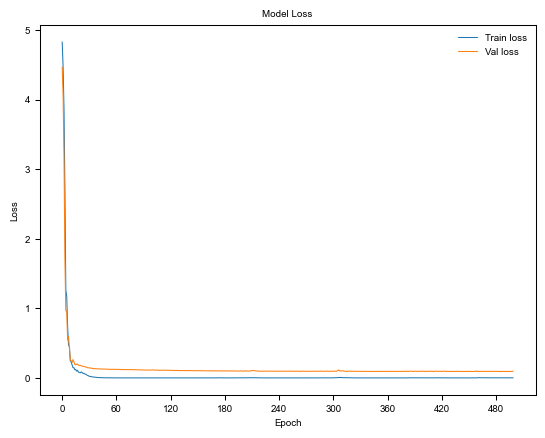

In [110]:
plot_loss(anion_mlp_train_loss_25, anion_mlp_val_loss_25)

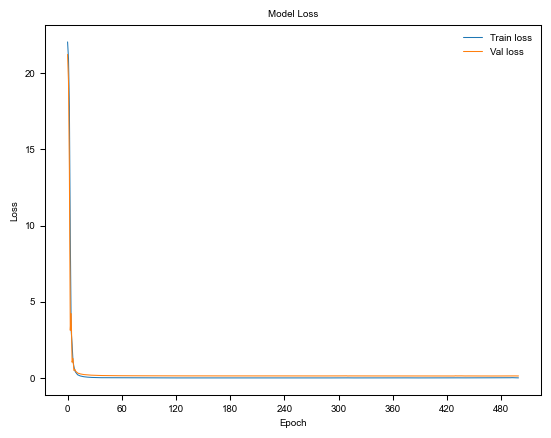

In [111]:
plot_loss(cation_mlp_train_loss_25, cation_mlp_val_loss_25)

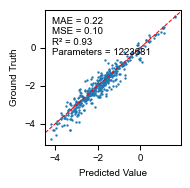

In [112]:
plot_targets(anion_mlp_val_pred_25, anion_mlp_val_true_25, anion_mlp_mse_25, anion_mlp_mae_25, save_path="anion_MLP_val_25.png")

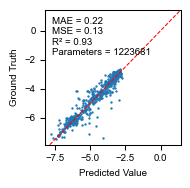

In [113]:
plot_targets(cation_mlp_val_pred_25, cation_mlp_val_true_25, cation_mlp_mse_25, cation_mlp_mae_25, save_path="cation_MLP_val_25.png")

# 50% train dataset

In [53]:
anion_50_load_train_dataset_path = 'dataset/train_anion_data_list_50.pt' 
anion_50_loaded_train_data_list = load_data_list(anion_50_load_train_dataset_path)
anion_50_train_loader = DataLoader(anion_50_loaded_train_data_list, batch_size=128, shuffle=True)  

cation_50_load_train_dataset_path = 'dataset/train_cation_data_list_50.pt'
cation_50_loaded_train_data_list = load_data_list(cation_50_load_train_dataset_path)
cation_50_train_loader = DataLoader(cation_50_loaded_train_data_list, batch_size=128, shuffle=True)  

In [55]:
model_anion_50 = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device) 
model_cation_50 = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device)

In [56]:
anion_mlp_train_loss_50, anion_mlp_val_loss_50, anion_mlp_train_pred_50, anion_mlp_train_true_50, anion_mlp_val_pred_50, anion_mlp_val_true_50, anion_mlp_mse_50, anion_mlp_mae_50 = train_epochs(
    11, epochs,model_anion_50, anion_50_train_loader, anion_val_loader, "Anion_MLP_model_HOMO_50.pt"
)

Epoch: 0, Train loss: 5.3037, Val loss: 4.8968
Epoch: 2, Train loss: 3.9500, Val loss: 2.5883
Epoch: 4, Train loss: 1.1588, Val loss: 0.5923
Epoch: 6, Train loss: 0.3965, Val loss: 0.2708
Epoch: 8, Train loss: 0.2134, Val loss: 0.2099
Epoch: 10, Train loss: 0.1470, Val loss: 0.1561
Epoch: 12, Train loss: 0.1110, Val loss: 0.1264
Epoch: 14, Train loss: 0.0891, Val loss: 0.1101
Epoch: 16, Train loss: 0.0644, Val loss: 0.0912
Epoch: 18, Train loss: 0.0366, Val loss: 0.0798
Epoch: 20, Train loss: 0.0255, Val loss: 0.0695
Epoch: 22, Train loss: 0.0186, Val loss: 0.0645
Epoch: 24, Train loss: 0.0138, Val loss: 0.0585
Epoch: 26, Train loss: 0.0108, Val loss: 0.0566
Epoch: 28, Train loss: 0.0089, Val loss: 0.0547
Epoch: 30, Train loss: 0.0076, Val loss: 0.0541
Epoch: 32, Train loss: 0.0066, Val loss: 0.0536
Epoch: 34, Train loss: 0.0058, Val loss: 0.0523
Epoch: 36, Train loss: 0.0050, Val loss: 0.0523
Epoch: 38, Train loss: 0.0044, Val loss: 0.0520
Epoch: 40, Train loss: 0.0045, Val loss: 0.05

In [57]:
cation_mlp_train_loss_50, cation_mlp_val_loss_50, cation_mlp_train_pred_50, cation_mlp_train_true_50, cation_mlp_val_pred_50, cation_mlp_val_true_50, cation_mlp_mse_50, cation_mlp_mae_50 = train_epochs(
    12, epochs,model_cation_50, cation_50_train_loader, cation_val_loader, "Cation_MLP_model_LUMO_50.pt"
)

Epoch: 0, Train loss: 23.8664, Val loss: 22.3543
Epoch: 2, Train loss: 6.8478, Val loss: 4.6777
Epoch: 4, Train loss: 0.8348, Val loss: 0.6519
Epoch: 6, Train loss: 0.3035, Val loss: 0.3173
Epoch: 8, Train loss: 0.1715, Val loss: 0.2370
Epoch: 10, Train loss: 0.1130, Val loss: 0.1940
Epoch: 12, Train loss: 0.0806, Val loss: 0.1677
Epoch: 14, Train loss: 0.0619, Val loss: 0.1513
Epoch: 16, Train loss: 0.0500, Val loss: 0.1399
Epoch: 18, Train loss: 0.0430, Val loss: 0.1333
Epoch: 20, Train loss: 0.0375, Val loss: 0.1269
Epoch: 22, Train loss: 0.0326, Val loss: 0.1212
Epoch: 24, Train loss: 0.0285, Val loss: 0.1182
Epoch: 26, Train loss: 0.0261, Val loss: 0.1146
Epoch: 28, Train loss: 0.0241, Val loss: 0.1135
Epoch: 30, Train loss: 0.0225, Val loss: 0.1114
Epoch: 32, Train loss: 0.0208, Val loss: 0.1092
Epoch: 34, Train loss: 0.0195, Val loss: 0.1085
Epoch: 36, Train loss: 0.0201, Val loss: 0.1099
Epoch: 38, Train loss: 0.0199, Val loss: 0.1065
Epoch: 40, Train loss: 0.0183, Val loss: 0.

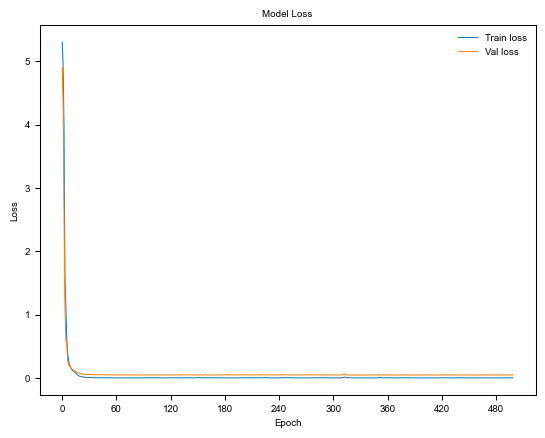

In [58]:
plot_loss(anion_mlp_train_loss_50, anion_mlp_val_loss_50)

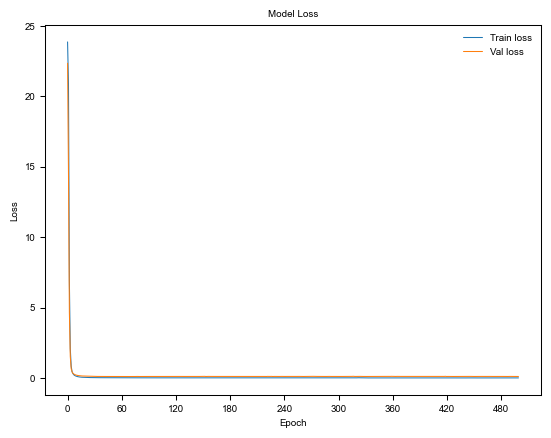

In [59]:
plot_loss(cation_mlp_train_loss_50, cation_mlp_val_loss_50)

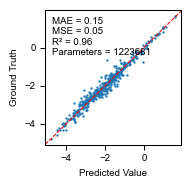

In [66]:
plot_targets(anion_mlp_val_pred_50, anion_mlp_val_true_50, anion_mlp_mse_50, anion_mlp_mae_50, save_path="anion_MLP_val_50.png")

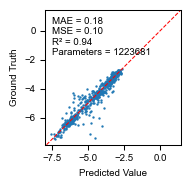

In [67]:
plot_targets(cation_mlp_val_pred_50, cation_mlp_val_true_50, cation_mlp_mse_50, cation_mlp_mae_50, save_path="cation_MLP_val_50.png")

# 75% train dataset

In [60]:
# Load the anion training set
anion_75_load_train_dataset_path = 'dataset/train_anion_data_list_75.pt' # Training set
anion_75_loaded_train_data_list = load_data_list(anion_75_load_train_dataset_path)
anion_75_train_loader = DataLoader(anion_75_loaded_train_data_list, batch_size=128, shuffle=True)  

# Load the cation training set
cation_75_load_train_dataset_path = 'dataset/train_cation_data_list_75.pt' # Training set
cation_75_loaded_train_data_list = load_data_list(cation_75_load_train_dataset_path)
cation_75_train_loader = DataLoader(cation_75_loaded_train_data_list, batch_size=128, shuffle=True)  

In [68]:
model_anion_75 = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device)
model_cation_75 = MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size).to(device)

In [69]:
anion_mlp_train_loss_75, anion_mlp_val_loss_75, anion_mlp_train_pred_75, anion_mlp_train_true_75, anion_mlp_val_pred_75, anion_mlp_val_true_75, anion_mlp_mse_75, anion_mlp_mae_75 = train_epochs(
    11, epochs,model_anion_75, anion_75_train_loader, anion_val_loader, "Anion_MLP_model_HOMO_75.pt"
)

Epoch: 0, Train loss: 5.0627, Val loss: 4.6461
Epoch: 2, Train loss: 1.6779, Val loss: 1.1884
Epoch: 4, Train loss: 0.3820, Val loss: 0.2760
Epoch: 6, Train loss: 0.1685, Val loss: 0.1758
Epoch: 8, Train loss: 0.1143, Val loss: 0.1451
Epoch: 10, Train loss: 0.0838, Val loss: 0.1216
Epoch: 12, Train loss: 0.0471, Val loss: 0.1000
Epoch: 14, Train loss: 0.0326, Val loss: 0.0952
Epoch: 16, Train loss: 0.0236, Val loss: 0.0837
Epoch: 18, Train loss: 0.0198, Val loss: 0.0798
Epoch: 20, Train loss: 0.0152, Val loss: 0.0771
Epoch: 22, Train loss: 0.0126, Val loss: 0.0721
Epoch: 24, Train loss: 0.0112, Val loss: 0.0698
Epoch: 26, Train loss: 0.0094, Val loss: 0.0685
Epoch: 28, Train loss: 0.0084, Val loss: 0.0676
Epoch: 30, Train loss: 0.0071, Val loss: 0.0654
Epoch: 32, Train loss: 0.0063, Val loss: 0.0644
Epoch: 34, Train loss: 0.0068, Val loss: 0.0674
Epoch: 36, Train loss: 0.0067, Val loss: 0.0627
Epoch: 38, Train loss: 0.0067, Val loss: 0.0668
Epoch: 40, Train loss: 0.0049, Val loss: 0.06

In [75]:
cation_mlp_train_loss_75, cation_mlp_val_loss_75, cation_mlp_train_pred_75, cation_mlp_train_true_75, cation_mlp_val_pred_75, cation_mlp_val_true_75, cation_mlp_mse_75, cation_mlp_mae_75 = train_epochs(
    12, epochs,model_cation_75, cation_75_train_loader, cation_val_loader, "Cation_MLP_model_HOMO_75.pt"
)

Epoch: 0, Train loss: 8.2294, Val loss: 3.2093
Epoch: 2, Train loss: 0.4301, Val loss: 0.2825
Epoch: 4, Train loss: 0.1507, Val loss: 0.1608
Epoch: 6, Train loss: 0.0926, Val loss: 0.1239
Epoch: 8, Train loss: 0.0667, Val loss: 0.1062
Epoch: 10, Train loss: 0.0518, Val loss: 0.0979
Epoch: 12, Train loss: 0.0424, Val loss: 0.0939
Epoch: 14, Train loss: 0.0360, Val loss: 0.0939
Epoch: 16, Train loss: 0.0302, Val loss: 0.0925
Epoch: 18, Train loss: 0.0261, Val loss: 0.0915
Epoch: 20, Train loss: 0.0231, Val loss: 0.0921
Epoch: 22, Train loss: 0.0204, Val loss: 0.0932
Epoch: 24, Train loss: 0.0182, Val loss: 0.0924
Epoch: 26, Train loss: 0.0169, Val loss: 0.0936
Epoch: 28, Train loss: 0.0153, Val loss: 0.0948
Epoch: 30, Train loss: 0.0142, Val loss: 0.0941
Epoch: 32, Train loss: 0.0135, Val loss: 0.0935
Epoch: 34, Train loss: 0.0124, Val loss: 0.0942
Epoch: 36, Train loss: 0.0121, Val loss: 0.0937
Epoch: 38, Train loss: 0.0111, Val loss: 0.0941
Epoch: 40, Train loss: 0.0106, Val loss: 0.09

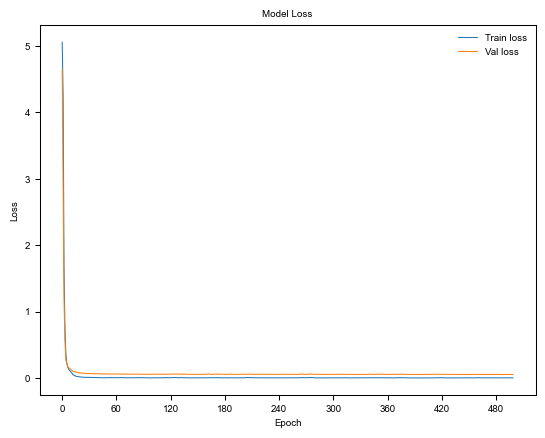

In [76]:
plot_loss(anion_mlp_train_loss_75, anion_mlp_val_loss_75)

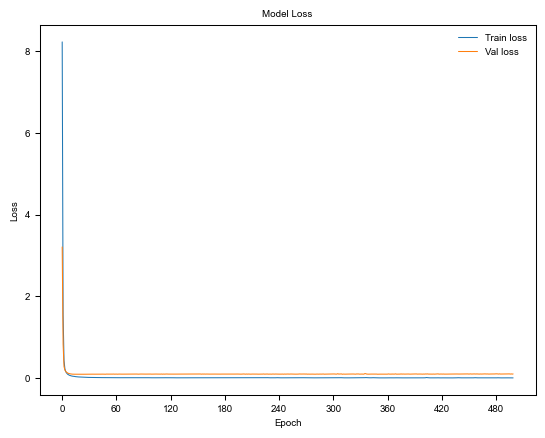

In [77]:
plot_loss(cation_mlp_train_loss_75, cation_mlp_val_loss_75)

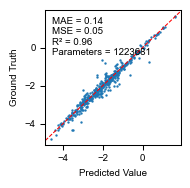

In [78]:
plot_targets(anion_mlp_val_pred_75, anion_mlp_val_true_75, anion_mlp_mse_75, anion_mlp_mae_75, save_path="anion_MLP_val_75.png")

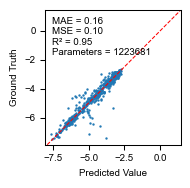

In [79]:
plot_targets(cation_mlp_val_pred_75, cation_mlp_val_true_75, cation_mlp_mse_75, cation_mlp_mae_75, save_path="cation_MLP_val_75.png")